# Example using electric guitar real audio data
In this notebook the model for pitch detection using the LOO-3 (leave one out for 3 tones) approach is tested on real audio corresponding to electric guitar.

In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

In [2]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift, fftshift
import soundfile

In [3]:
#np.random.seed(29)
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

### Load training data
In this case we have three recordings of isolated sound events.

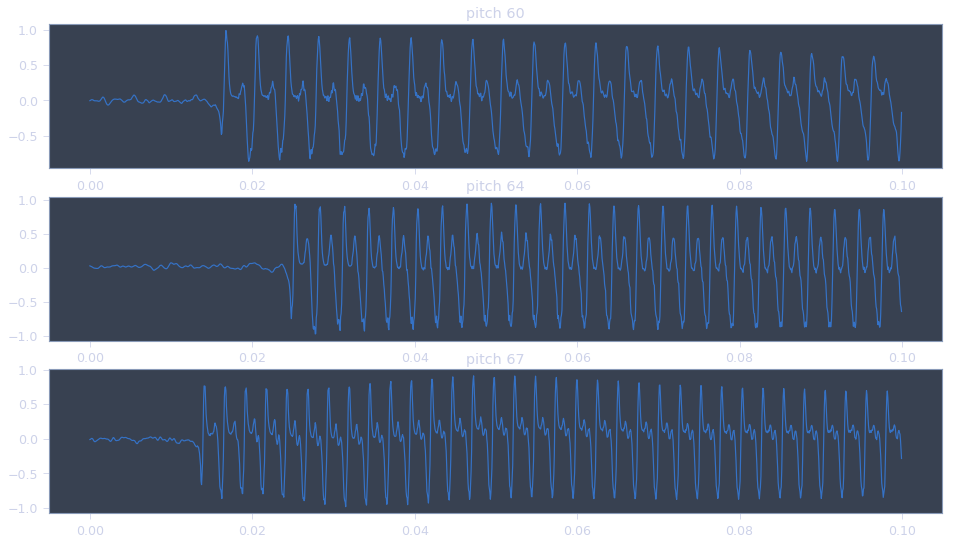

In [4]:
plist = np.asarray(['60', '64', '67'])
N, Np = 1600, plist.size  # number of frames, pitches
ytrain = np.zeros((N, Np)) 
plt.figure(figsize=(16, 3*3))
for i in range(Np):  # load training data
    filename = '../../../../datasets/fender/train/m_' + plist[i] + '.wav'
    ytrain[:,i], fs = soundfile.read(filename, start=700, frames=N) 
    xtrain = np.linspace(0, (N-1.)/fs, N)
    plt.subplot(3,1,i+1)
    plt.title('pitch ' + plist[i])
    plt.plot(xtrain, ytrain[:,i])

### Load test data
The mixture signal corresponds to play up to three tones at the same time.

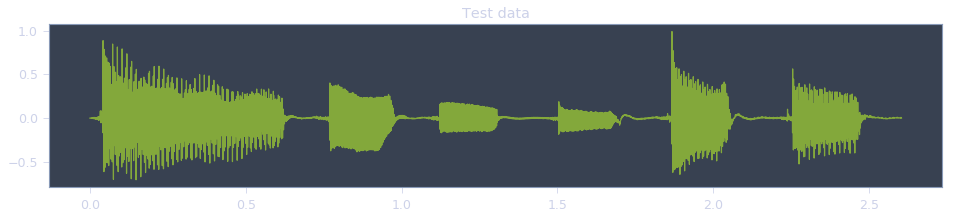

In [5]:
ytest, fs = soundfile.read('../../../../datasets/fender/test/test_data.wav')
Ntest = ytest.size
xtest = np.linspace(0,(Ntest-1.)/fs, Ntest )
plt.figure(), plt.title('Test data')
plt.plot(xtest, ytest, 'C1')

### Define model
In this section we initialize the model only once. We first define 2 activation and 2 component kernels. Then we define the LOO model.

In [6]:
init_model = True  # run this only once to define the graph
if init_model:  # init model (build graph only once)
    Nh = 15  # number of maximun harmonics per component
    k1_act = gpflow.kernels.Matern32(1)  # activation pitch to detect
    k2_act = gpflow.kernels.Matern32(1) # activation background
    k1_com = gpitch.kernels.MaternSpecMix(Nh)  # component pitch to detect 
    k2_com = gpitch.kernels.MaternSpecMix((Np-1)*Nh)  # component background
    ka, kc = [k1_act, k2_act], [k1_com, k2_com]
    dec, ws = 160, N  # decimation factor, window size in frames
    model = gpitch.loopdet.LooPDet(x=xtest, y=ytest, ker_com=kc, ker_act=ka, ws=ws, 
                                   plist=plist, dec=dec)
    model.m.likelihood.noise_var = 1e-3
    model.m.kern_f1.fixed = True
    model.m.kern_f2.fixed = True
    model.m.kern_g1.fixed = True
    model.m.kern_g2.fixed = False
    model.m.likelihood.noise_var.fixed = True

### Learn or load parameters
Here we decide whether to run training or load previously learned parameters.

In [ ]:
f_star, s_star, F, Y, S

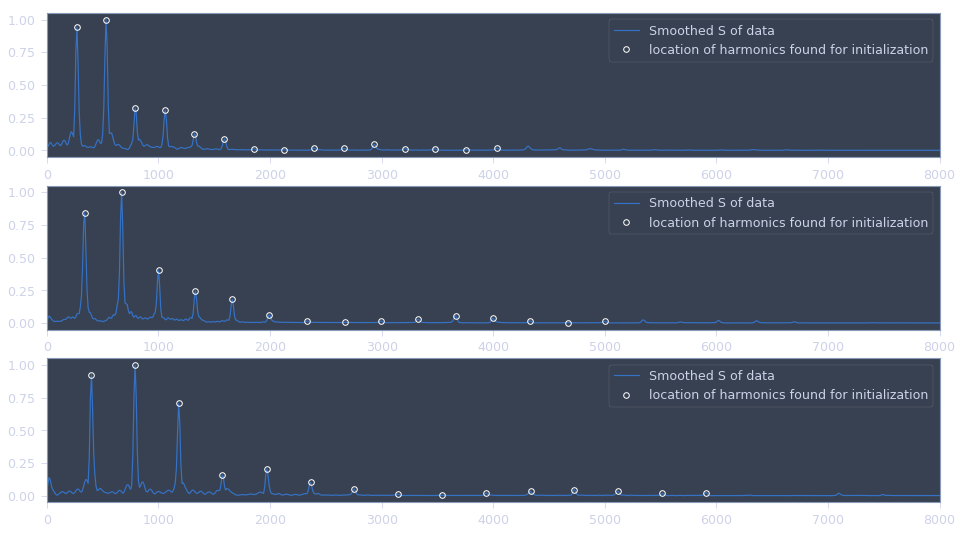

In [24]:
params = model.learnparams(xtrain=xtrain, ytrain=ytrain, fs=fs, Nh=Nh, 
                                            run_training=True)

plt.figure(figsize=(16, 3*3))
for i in range(plist.size):
    plt.subplot(3, 1, i+1)
    plt.plot(params[i][2], params[i][4] / np.max( params[i][4]))
    plt.plot(params[i][0],params[i][1] / np.max( params[i][1]), 'ow', mfc='none', mew=1)
    plt.legend(['Smoothed S of data', 'location of harmonics found for initialization'])
    plt.xlim([0, 8000])

## Pitch detection